In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
import pandas as pd
from scipy import optimize

In [3]:
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
rho_0 = 0.5
v = 0
delta_u = 1.
mu_M = 0.00001
mu_Q = 0.00001
tau_G = 10.
tau_baseline = 100.
dt = 1.

In [4]:
num_neurons = 30
num_timebins = 1000

weights = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
# weights = np.array(
#     [[0, 0.1],
#     [0, 0]]
# )
# weights = np.ones((num_neurons, num_neurons))
np.fill_diagonal(weights, 0)
phi = np.zeros(shape = (num_neurons, num_timebins))
rho = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights, phi[:, 0]) - eta[:, 0]
rho[:, 0] = rho_0 * np.exp(u[:, 0])
spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])



In [5]:

for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

In [26]:
gaussian_intervals = np.random.normal(size = 100, loc=30, scale=10).astype(int)

In [24]:
## staircase pattern
neuron_block_size = np.floor(num_neurons / 3)
curr_neuron_block = 0
interval_idx = 0
timebin_counter = 0
    
for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
    
    rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 1.0


#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])
    
    
    
        
    timebin_counter += 1
    if timebin_counter == gaussian_intervals[interval_idx]:
        interval_idx += 1
        timebin_counter = 0
        if curr_neuron_block < 2:
            curr_neuron_block += 1
        else:
            curr_neuron_block = 0

Text(159,0.5,'neuron index')

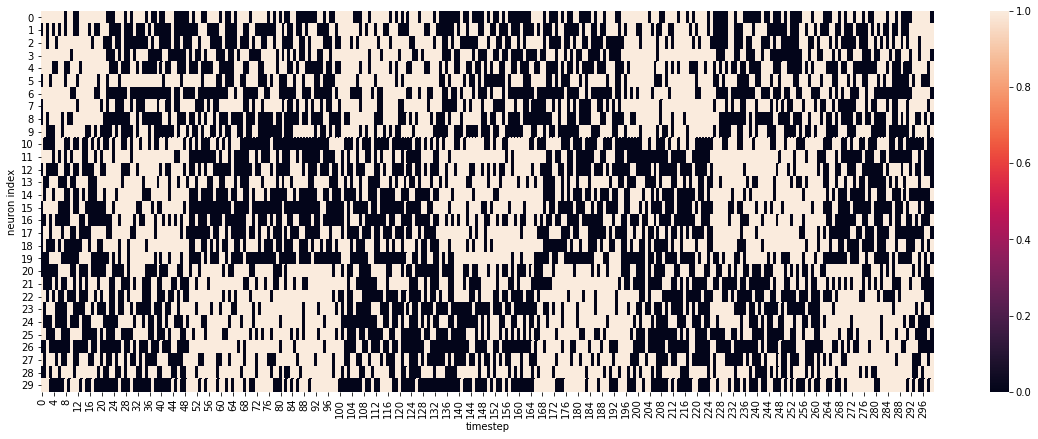

In [25]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(spikes[:, :300])
plt.xlabel("timestep")
plt.ylabel("neuron index")

In [6]:
def log_likelihood(curr_weights):

#     total_potential = np.matmul(curr_weights, phi) - eta_0 * eta[0, :]

#     rho[0, :] = rho_0 * np.exp((total_potential - v) / delta_u)
#     LL = np.sum(np.multiply(np.log(rho[0, :]), spikes[0, :]) - rho[0, :]) * dt

    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    rho = rho_0 * np.exp((total_potential - v) / delta_u)
    LL = np.sum(np.multiply(np.log(rho), spikes) - rho) * dt

    return -LL

In [7]:
# total_potential = np.matmul(x0, phi) - eta_0 * eta

# rho = rho_0 * np.exp((total_potential - v) / delta_u)
# LL = np.sum(np.multiply(np.log(rho), spikes) - rho) * dt

In [8]:
# x0 = np.random.normal(loc=0, scale=0.1, size=num_neurons)
x0 = np.random.normal(loc=0, scale=0.1, size=[num_neurons, num_neurons])
res = optimize.minimize(log_likelihood, x0, options={'disp': True}, tol=1e-5)

KeyboardInterrupt: 

In [ ]:
# print np.sum((res.x - weights[0, :])**2)
print np.sum((np.reshape(res.x, [num_neurons, num_neurons]) - weights)**2)

In [174]:
# for tt in range(1, num_timebins):

#     for ii in range(num_neurons):

#         dphi = dt * (1 / tau) * (spikes[:, tt - 1] - learned_phi[:, tt - 1])
#         deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - learned_eta[:, tt - 1])

#         learned_phi[:, tt] = learned_phi[:, tt - 1] + dphi
#         learned_eta[:, tt] = learned_eta[:, tt - 1] + deta

#         total_potential = np.matmul(x0, phi[:, tt]) - eta_0 * eta[:, tt]
#         learned_u[:, tt] = total_potential

#         learned_rho[:, tt] = rho_0 * np.exp((learned_u[:, tt] - v) / delta_u)
#     LL = np.sum(np.sum(np.multiply(np.log(learned_rho), spikes) - learned_rho, axis = 1) * dt)

In [132]:
## FIRST NEURON

covariates = rho[1:, :].T
response = spikes[0, :].astype(int)

data_df = pd.DataFrame(np.hstack([covariates, np.reshape(response, [response.shape[0], 1])]))
new_colnames = ['n' + str(a) for a in np.arange(data_df.shape[1])]
new_colnames[-1] = "spike"
data_df.columns = new_colnames

formula_str = ''.join([x + " + " for x in data_df.columns[:-1]])[:-3]

gamma_model = sm.formula.glm("spike ~ " + formula_str, family=sm.families.Binomial(), data=data_df).fit()

# gamma_model.summary()


In [157]:
#### FITTING

learned_weights = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights, 0)
learned_phi = np.zeros(shape = (num_neurons, num_timebins))
learned_rho = np.zeros(shape = (num_neurons, num_timebins))
learned_eta = np.zeros(shape = (num_neurons, num_timebins))
learned_u = np.zeros(shape = (num_neurons, num_timebins))
# spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
learned_phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
learned_eta[:, 0] = np.zeros(num_neurons)
learned_u[:, 0] = np.matmul(learned_weights, phi[:, 0]) - eta[:, 0]
learned_rho[:, 0] = rho_0 * np.exp(learned_u[:, 0])
# spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
# spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])

num_iter = 100
mse_trace = []
LL_trace = []
mu_M = 0.0001


for iter_num in range(num_iter):
    for tt in range(1, num_timebins):

        for ii in range(num_neurons):

            dphi = dt * (1 / tau) * (spikes[:, tt - 1] - learned_phi[:, tt - 1])
            deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - learned_eta[:, tt - 1])

            learned_phi[:, tt] = learned_phi[:, tt - 1] + dphi
            learned_eta[:, tt] = learned_eta[:, tt - 1] + deta

            total_potential = np.matmul(learned_weights, phi[:, tt]) - eta_0 * eta[:, tt]
            learned_u[:, tt] = total_potential

            learned_rho[:, tt] = rho_0 * np.exp((learned_u[:, tt] - v) / delta_u)

    weight_gradient = np.matmul(spikes - learned_rho, phi.T) * dt
    learned_weights += mu_M * weight_gradient
    np.fill_diagonal(learned_weights, 0.0)
    
    curr_mse = np.mean((weights - learned_weights)**2)
    print curr_mse
    mse_trace.append(curr_mse)
    
    LL = np.sum(np.sum(np.multiply(np.log(learned_rho), spikes) - learned_rho, axis = 1) * dt)
    LL_trace.append(LL)

0.04214454828114651
0.13765920750520122
0.3719860521910262
0.8824694960105319
2.0533666056894226
5.802864216494511
417.62093962780614


KeyboardInterrupt: 

In [156]:
weight_gradient

0.47714198703513777

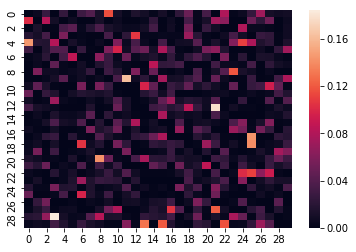

In [152]:
sns.heatmap((weights - learned_weights)**2)

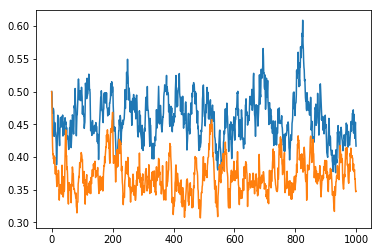

In [153]:
plt.plot(rho[0, :])
plt.plot(learned_rho[0, :])

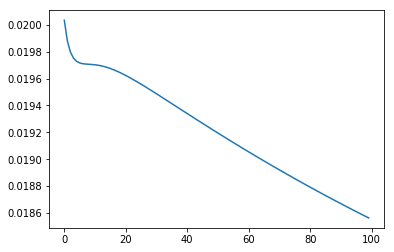

In [154]:
plt.plot(mse_trace)